# Introduction
* This notebook contains the submission to MIDAS 2021 Summer Internship Task 3.
* The task is to classify the product category based on the product's description.
* The product's description has to be extracted from the product category tree.
* The dataset at hand is the Flipkart e-commerce sales sample dataset containing about 20k samples.
* Standard machine learning models (Multinomial Naive Bayes, Random Forest, and Linear SVC) are used as they give pretty good accuracy.
* Confusion matrix as well as the performance analysis of each model is provided at the end.

# Importing Necessary Modules

In [4]:
import pandas as pd
import numpy as np
import re
import spacy
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import metrics
from sklearn import naive_bayes
from sklearn.svm import LinearSVC
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn import ensemble
from sklearn.svm import LinearSVC
import joblib
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wgmlgz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wgmlgz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Class Utils:
It is a class containing various functions needed for this task.

In [7]:
class Utils():


    # -------------------------------------------- constructor --------------------------------------------
    
    def __init__(self):
        """ Class Constructor """
        self.stop_words = stopwords.words('english')
        unwanted_stopwords = {'no', 'nor', 'not', 'ain', 'aren', "aren't", 'couldn', 'what', 'which', 'who',
                                      'whom',
                                      'why', 'how', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't",
                                      'hasn',
                                      "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
                                      "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
                                      "wasn't",
                                      'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't", 'don', "don't"}

        self.stop_words = [ele for ele in self.stop_words if ele not in unwanted_stopwords]
        self.wordnet_lemmatizer = WordNetLemmatizer()
        self.nouns = ['NNP', 'NNPS']
        self.nlp = spacy.load('en_core_web_lg')
        self.label_encoder = LabelEncoder()


    # -------------------------------------------- Function to read data --------------------------------------------
    
    def read_data(self, path, sep=",", usecols=[]):
        """ Function to read the data
        @param path (str): path to the dataset
        @param df (pd.DataFrame): pandas DataFrame.
        """
        return pd.read_csv(path, 
                           sep=sep,  
                           usecols=usecols)
        



    # -------------------------------------------- Function to decide main categories --------------------------------------------
    
    def generate_label(self, df, top=5):
        """ Function to generate labels
        @param df (pd.DataFrame): input data.
        @param top (int): The number of labels to have.
        """
        df['label'] = df.product_category_tree.apply(lambda x: x.split('>>')[0][2:].strip())
        top_categories = list(df.groupby('label').count().sort_values(by='uniq_id',ascending=False).head(top).index)
        df = df[df['label'].isin(top_categories)]
        return df
        
        
        
        
        
       
    # -------------------------------------------- Function to clean text --------------------------------------------
    
    def clean_text(self, text, remove_stopwords=True, lemmatize=True):
        """ Function to clean text
        @param text (str): text to be cleaned
        @param remove_stopwords (bool): To remove stopwords or not.
        @param lemmatize (bool): to lemmatize or not.
        """

        # Remove emails 
        text = re.sub('\S*@\S*\s?', '', text)
        
        # Remove new line characters 
        text = re.sub('\s+', ' ', text) 
        
        # Remove distracting single quotes 
        text = re.sub("\'", '', text)

        # Remove puntuations and numbers
        text = re.sub('[^a-zA-Z]', ' ', text)

        # Remove single characters
        text = re.sub('\s+[a-zA-Z]\s+^I', ' ', text)
        
        # Remove accented words
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

        # remove multiple spaces
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'^\s*|\s\s*', ' ', text).strip()
        text = text.lower()

        if not remove_stopwords and not lemmatize:
            return text

        # Remove unncecessay stopwords
        if remove_stopwords:
            text = word_tokenize(text)
            text = " ".join([word for word in text if word not in self.stop_words])
        
        # Word lemmatization
        if lemmatize:
            text = self.nlp(text)
            lemmatized_text = []
            for word in text:
                if word.lemma_.isalpha():
                    if word.lemma_ != '-PRON-':
                        lemmatized_text.append(word.lemma_.lower())
            text = " ".join([word.lower() for word in lemmatized_text])
                
        return text
        
        
        
        
        
    # -------------------------------------------- Function to prepare data for the model --------------------------------------------    
    
    def prepare_data(self, df, test_size=0.2, remove_stopwords=True, lemmatize=True):
        """ Function to prepare data for model.
        @param df (pd.DataFrame): input data.
        @param test_size (float): train-test split ratio.
        """
        df = df.sample(frac=1).reset_index(drop=True)
        description = df['description'].apply(lambda x: self.clean_text(str(x), remove_stopwords=remove_stopwords, lemmatize=lemmatize))
        labels = df['label'].values.tolist()
        labels = self.label_encoder.fit_transform(labels)
        x_train, x_test, y_train, y_test = train_test_split(description, 
                                                            labels, 
                                                            test_size=test_size, 
                                                            stratify=labels)
        return x_train, x_test, y_train, y_test
        
        
        
        
                
    



    # ------------------------------------- GENERATE COUNT FEATURES AS VECTORS---------------------------------

    def count_vectorize(self, X_train, X_test, analyzer='word', token_pattern=r'\w{1,}', max_features=10000, ngram_range=(1,1)):
        """ Function to count vectorize the text data.
        @param X_train (list): list of input train text data.
        @param X_val (list): list of input test text data.
        @param analyzer (string): Whether the feature should be made of word n-gram or character n-grams.(‘word’, ‘char’, ‘char_wb')
        @param token_pattern (string): Regular expression denoting what constitutes a “token”.
        @param max_features (int): Max no. of words to build your vocab.
        @param ngram_range (tuple): The lower and upper boundary of the range of n-values for different word n-grams or char n-grams to be extracted.
        @return xtrain_count(list): count vectorized train data.
        @return xvalid_count(list): count vectorized test data.
        """
        if analyzer == 'word':
            count_vect = CountVectorizer(analyzer=analyzer, 
                                         token_pattern=token_pattern,
                                         max_features=max_features,
                                         ngram_range=ngram_range)
        else:
            count_vect = CountVectorizer(analyzer=analyzer, 
                                     max_features=max_features,
                                     ngram_range=ngram_range)
        count_vect.fit(X_train)

        # transform the training and validation data using count vectorizer object
        xtrain_count = count_vect.transform(X_train)
        xvalid_count = count_vect.transform(X_test)

        return xtrain_count, xvalid_count

    
    

    # ---------------------- GENERATE WORD LEVEL TF-IDF FEATURES AS VECTORS---------------------------------

    def tf_idf_vectorize(self, X_train, X_test, analyzer='word', token_pattern=r'\w{1,}', max_features=10000, ngram_range=(1,1)):
        """ Function to tf-idf vectorize the text data.
        @param X_train (list): list of input train text data.
        @param X_val (list): list of input test text data.
        @param analyzer (string): Whether the feature should be made of word n-gram or character n-grams.(‘word’, ‘char’, ‘char_wb')
        @param token_pattern (string): Regular expression denoting what constitutes a “token”.
        @param max_features (int): Max no. of words to build your vocab.
        @param ngram_range (tuple): The lower and upper boundary of the range of n-values for different word n-grams or char n-grams to be extracted.
        @return xtrain_tfidf(list): tf-idf vectorized train data.
        @return xvalid_tfidf(list): tf-idf vectorized test data.
        """
        if analyzer == 'word':
            tfidf_vect = TfidfVectorizer(analyzer=analyzer, 
                                         token_pattern=token_pattern,
                                         max_features=max_features,
                                         ngram_range=ngram_range)
        else:
            tfidf_vect = TfidfVectorizer(analyzer=analyzer, 
                                         max_features=max_features,
                                         ngram_range=ngram_range)
        
        tfidf_vect.fit(X_train)

        xtrain_tfidf = tfidf_vect.transform(X_train)
        xvalid_tfidf = tfidf_vect.transform(X_test)

        return xtrain_tfidf, xvalid_tfidf
         
        
     
    
    # ------------------------------------------------------ TRAIN ML MODELS --------------------------------------------
    def train_ml_model(self, classifier, X_train, X_test, y_train, y_test):
        """ Function to train and evaluate the model
        @param classifier (sklearn model): The ML model to be used.
        @param X_train (list): list of input train text data.
        @param X_test (list): list of input test text data.
        @param y_train (list): training data label.
        @param y_test (list): test data label.
        @return accuracy (float): accuracy of the model.
        """
        classifier.fit(X_train, y_train)
        predictions = classifier.predict(X_test)
        accuracy = metrics.accuracy_score(predictions, y_test)      
        return classifier, accuracy

In [13]:
utils = Utils()

## Evlaulating the performance using the top 10 most occuring categories as labels

In [14]:
data = utils.read_data("dataset.tsv", 
                       sep="\t", 
                       usecols=['uniq_id', 'product_name', 'product_category_tree', 'description'])
data

,uniq_id,product_name,product_category_tree,description
0,c2d766ca982eca8304150849735ffef9,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",Key Features of Alisha Solid Women's Cycling S...
1,7f7036a6d550aaa89d34c77bd39a5e48,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",FabHomeDecor Fabric Double Sofa Bed (Finish Co...
2,f449ec65dcbc041b6ae5e6a32717d01b,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",Key Features of AW Bellies Sandals Wedges Heel...
3,0973b37acd0c664e3de26e97e5571454,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",Key Features of Alisha Solid Women's Cycling S...
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",Specifications of Sicons All Purpose Arnica Do...
...,...,...,...,...
19995,7179d2f6c4ad50a17d014ca1d2815156,WallDesign Small Vinyl Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Buy WallDesign Small Vinyl Sticker for Rs.730 ...
19996,71ac419198359d37b8fe5e3fffdfee09,Wallmantra Large Vinyl Stickers Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Buy Wallmantra Large Vinyl Stickers Sticker fo...
19997,93e9d343837400ce0d7980874ece471c,Elite Collection Medium Acrylic Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Buy Elite Collection Medium Acrylic Sticker fo...
19998,669e79b8fa5d9ae020841c0c97d5e935,Elite Collection Medium Acrylic Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Buy Elite Collection Medium Acrylic Sticker fo...


### generate_label function:
This function below is used to parse the product category tree and generate the primary label the product belongs to.

In [116]:
data = utils.generate_label(data, top=10)
data.label.value_counts()

C:\Users\wgmlgz\AppData\Local\Temp\ipykernel_7356\1844384763.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df.product_category_tree.apply(lambda x: x.split('>>')[0][2:].strip())


Clothing                      6198
Jewellery                     3531
Footwear                      1227
Mobiles & Accessories         1099
Automotive                    1012
Home Decor & Festive Needs     929
Beauty and Personal Care       710
Home Furnishing                700
Kitchen & Dining               647
Computers                      578
Name: label, dtype: int64

As we can see below 16,631 samples out of the total 20k samples cover the top 10 categories which is about 83% of the total data (not bad!).

In [117]:
print(len(data))

16631


(array([   0., 1000., 2000., 3000., 4000., 5000., 6000., 7000.]),
 [Text(0.0, 0, '0'),
  Text(1000.0, 0, '1000'),
  Text(2000.0, 0, '2000'),
  Text(3000.0, 0, '3000'),
  Text(4000.0, 0, '4000'),
  Text(5000.0, 0, '5000'),
  Text(6000.0, 0, '6000'),
  Text(7000.0, 0, '7000')])

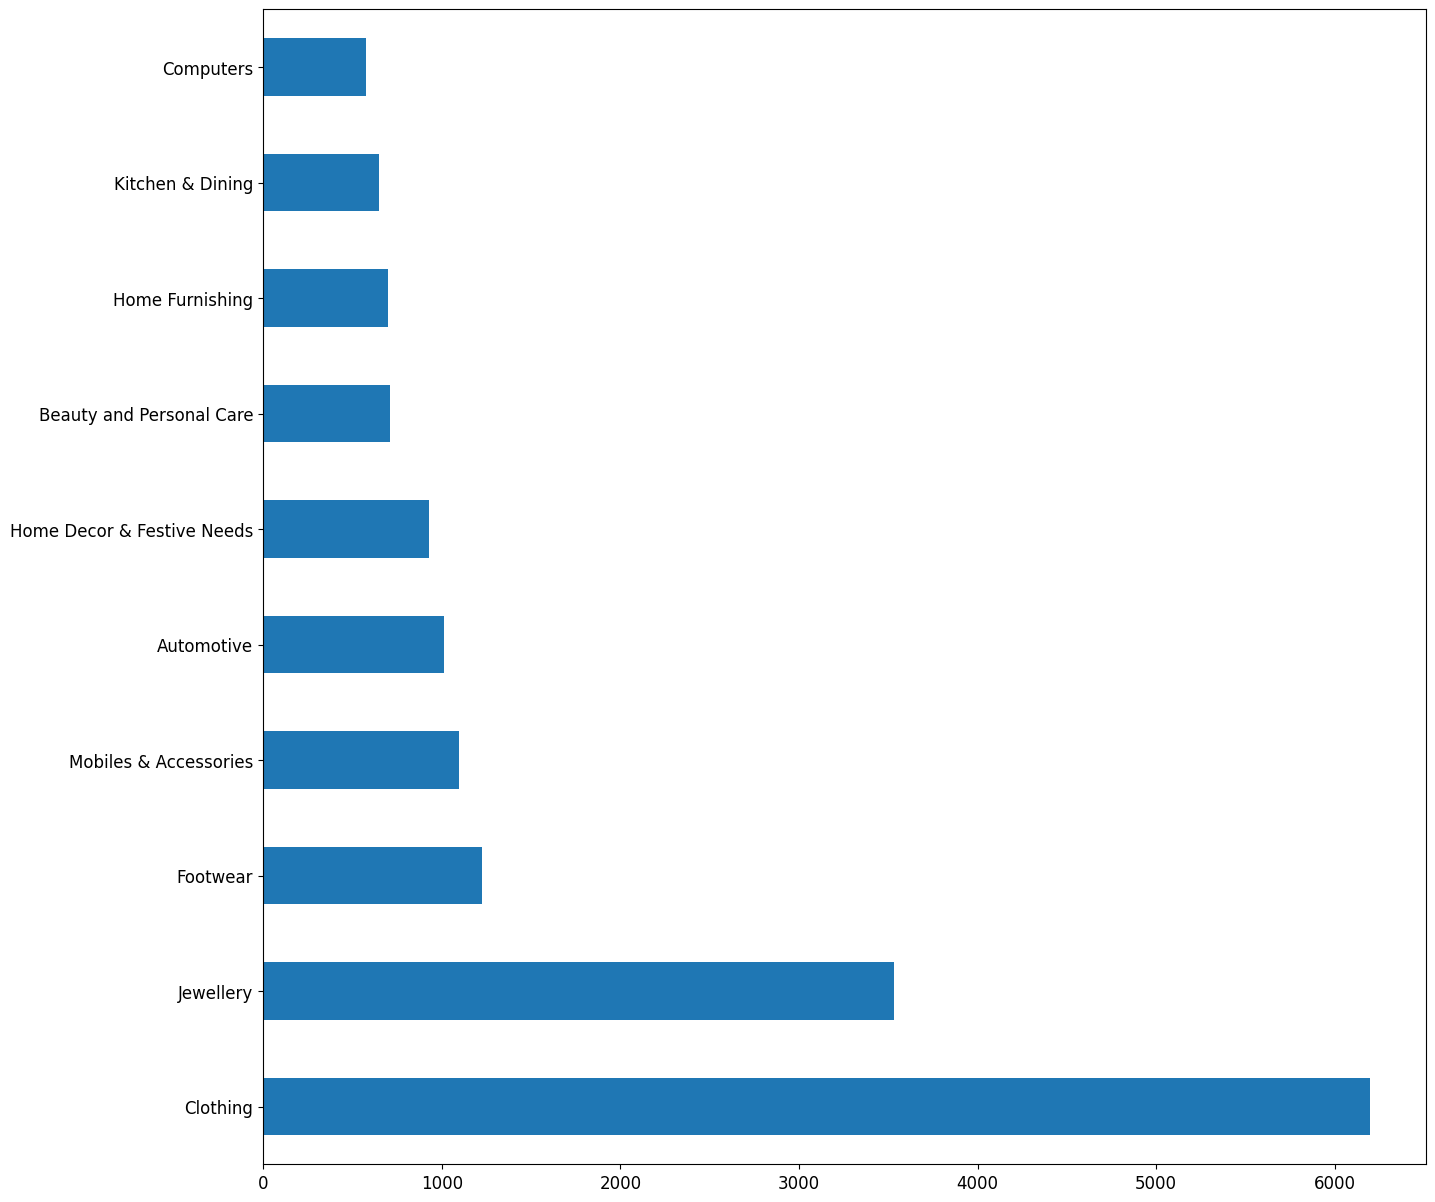

In [17]:
plt.figure(figsize=(15,15))
data['label'].value_counts().sort_values(ascending=False).plot(kind='barh')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

## prepare_data function:
* It is used to preprocess the textual description and prepare labels.
* The text preprocessing includes removing emails, new line characters, distracting single quotes, digits, puntuations, single characters, accented words, and multiple spaces.
* Removal of the stopwords (except the negation words) and lemmatization is optional. However, the lemmatizaiton and stopwords removal is done as it gives empirically improves performance.
* It also splits the data into train and test sets.
* A stratified 70:30 train-test split is used, which gives 11,641 train samples and 4,990 test samples when the top 10 product categories are included.

In [56]:
x_train, x_test, y_train, y_test = utils.prepare_data(data, test_size=0.3, remove_stopwords=True, lemmatize=True)

print("Total training examples: ", len(x_train))
print("Total test examples: ", len(x_test))

Total training examples:  11641
Total test examples:  4990


In [53]:
print(x_test)
print(y_train)
print(max(y_test))

1901     provogue slim fit men jeans buy blue provogue ...
3012     nineteen women stripe casual shirt buy pink ni...
2306     key feature lock lock kitchen l polypropylene ...
3630     key feature yoshana girl layer purple dress yo...
4609     diti jewellery ct certify diamond rd gift free...
                               ...                        
3842     police slim fit men jeans price rs cotton lycr...
8061     parron men solid casual shirt price rs parron ...
8176     buy destudio tiny wall sticker rs online destu...
13933    women full coverage bra price rs bring range s...
10417    lee mark men solid formal shirt price rs lee m...
Name: description, Length: 4990, dtype: object
[7 4 2 ... 3 5 0]
9


## Feature Engineering:
* The ML models cannot handle textual data. So it needs to be converted to a numeric format.
* 7 feature engineering techniques to convert the input textual descriptions into numeric features.
    1. Word frequency based representation (only unigrams).
    2. Word frequency based representation (unigrams and bigrams).
    3. Word frequency based representation (unigrams, bigrams, and trigrams).
    4. Word TF-IDF based representation (only unigrams).
    5. Word TF-IDF based representation (unigrams and bigrams).
    6. Word TF-IDF based representation (unigrams, bigrams, and trigrams).
    7. Character TF-IDF based representation (bigrams and trigrams).

In [82]:
# Word frequency based representation (only unigrams)
xtrain_count, xvalid_count = utils.count_vectorize(x_train, 
                                                   x_test,
                                                   analyzer='word', 
                                                   token_pattern=r'\w{1,}', 
                                                   max_features=10000, 
                                                   ngram_range=(1,1))

# Word frequency based representation (unigrams and bigrams)
xtrain_count_bi, xvalid_count_bi = utils.count_vectorize(x_train, 
                                                         x_test,
                                                         analyzer='word', 
                                                         token_pattern=r'\w{1,}', 
                                                         max_features=10000, 
                                                         ngram_range=(1,2))

xtrain_count_ngram, xvalid_count_ngram = utils.count_vectorize(x_train, 
                                                               x_test,
                                                               analyzer='word', 
                                                               token_pattern=r'\w{1,}', 
                                                               max_features=10000, 
                                                               ngram_range=(1,3))


xtrain_tfidf, xvalid_tfidf = utils.tf_idf_vectorize(x_train, 
                                                    x_test, 
                                                    analyzer='word', 
                                                    token_pattern=r'\w{1,}', 
                                                    max_features=10000, 
                                                    ngram_range=(1,1))


xtrain_tfidf_bi, xvalid_tfidf_bi = utils.tf_idf_vectorize(x_train, 
                                                          x_test, 
                                                          analyzer='word', 
                                                          token_pattern=r'\w{1,}', 
                                                          max_features=10000, 
                                                          ngram_range=(1,2))


xtrain_tfidf_ngram, xvalid_tfidf_ngram = utils.tf_idf_vectorize(x_train, 
                                                                x_test,
                                                                analyzer='word', 
                                                                token_pattern=r'\w{1,}', 
                                                                max_features=10000, 
                                                                ngram_range=(1,3))

xtrain_tfidf_ngram_chars, xvalid_tfidf_ngram_chars = utils.tf_idf_vectorize(x_train, 
                                                                            x_test,
                                                                            analyzer='char', 
                                                                            token_pattern=r'\w{1,}', 
                                                                            max_features=10000, 
                                                                            ngram_range=(2,3))
print("\nPrepared features for Input data")


Prepared features for Input data


# Multinomial Naive Bayes

In [83]:
print("\n ----------------------------------- Evaluation on Multinomial Naive Bayes -----------------------------------n\n")
# Naive Bayes on Count Vectors
model1, accuracy = utils.train_ml_model(naive_bayes.MultinomialNB(), 
                                        xtrain_count, xvalid_count, 
                                        y_train, y_test)
print("Naive Bayes, Count Vectors: ", accuracy)

# Naive Bayes on bigram Count Vectors
model2, accuracy = utils.train_ml_model(naive_bayes.MultinomialNB(),
                                        xtrain_count_bi, xvalid_count_bi,
                                        y_train, y_test)
print("\nNaive Bayes, bigram Count Vectors: ", accuracy)

# Naive Bayes on ngram Count Vectors
model3, accuracy = utils.train_ml_model(naive_bayes.MultinomialNB(),
                                        xtrain_count_ngram, xvalid_count_ngram,
                                        y_train, y_test)
print("\nNaive Bayes, ngram Count Vectors: ", accuracy)

# Naive Bayes on Word Level TF IDF Vectors
model4, accuracy = utils.train_ml_model(naive_bayes.MultinomialNB(),
                                        xtrain_tfidf, xvalid_tfidf,
                                        y_train, y_test)
print("\nNaive Bayes, WordLevel TF-IDF: ", accuracy)

# Naive Bayes on Word Level bigram TF IDF Vectors
model5, accuracy = utils.train_ml_model(naive_bayes.MultinomialNB(),
                                        xtrain_tfidf_bi, xvalid_tfidf_bi,
                                        y_train, y_test)
print("\nNaive Bayes, WordLevel bigram TF-IDF: ", accuracy)

# Naive Bayes on Ngram Level TF IDF Vectors
model6, accuracy = utils.train_ml_model(naive_bayes.MultinomialNB(),
                                        xtrain_tfidf_ngram, xvalid_tfidf_ngram,
                                        y_train, y_test)
print("\nNaive Bayes, WordLevel ngram TF-IDF: ", accuracy)

# Naive Bayes on Character Level TF IDF Vectors
model7, accuracy = utils.train_ml_model(naive_bayes.MultinomialNB(),
                                        xtrain_tfidf_ngram_chars, xvalid_tfidf_ngram_chars,
                                        y_train, y_test)
print("\nNaive Bayes, CharLevel ngram TF-IDF: ", accuracy)



 ----------------------------------- Evaluation on Multinomial Naive Bayes -----------------------------------n

Naive Bayes, Count Vectors:  0.974749498997996

Naive Bayes, bigram Count Vectors:  0.9673346693386774

Naive Bayes, ngram Count Vectors:  0.9523046092184368

Naive Bayes, WordLevel TF-IDF:  0.9561122244488978

Naive Bayes, WordLevel bigram TF-IDF:  0.9751503006012024

Naive Bayes, WordLevel ngram TF-IDF:  0.9681362725450902

Naive Bayes, CharLevel ngram TF-IDF:  0.8735470941883767


In [152]:



count_vect = CountVectorizer(analyzer='word',
                             token_pattern=r'\w{1,}',
                             max_features=10000,
                             ngram_range=(1, 1))
count_vect.fit(x_train)

# print(data.label[predictions[0]])
# print(metrics.accuracy_score(predictions, real))


Home Decor & Festive Needs


In [153]:
def lookup(s):
  sus = x_test.iloc[0:1]
  d = {0: s}
  sus = pd.Series(d)
  trans_sus = count_vect.transform(sus)

  predictions = model1.predict(trans_sus)
  predictions = predictions[0]
  res = (data.label.value_counts().iloc[predictions: predictions + 1].keys()[0])
  return res

In [162]:
print(lookup('lamp'))
print(lookup('speed'))
print(lookup('phone'))
print(lookup('charger'))
print(lookup('pizza'))

Home Decor & Festive Needs
Footwear
Computers
Computers
Kitchen & Dining


## Performance Analysis:
* From the accuracies reported above, we can see that the simple unigram-based word frequency representations give the best results.
* Word TF-IDF based features also perform best.
* The confusion matrix below also show a reasonable performance across all the labels.

c:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


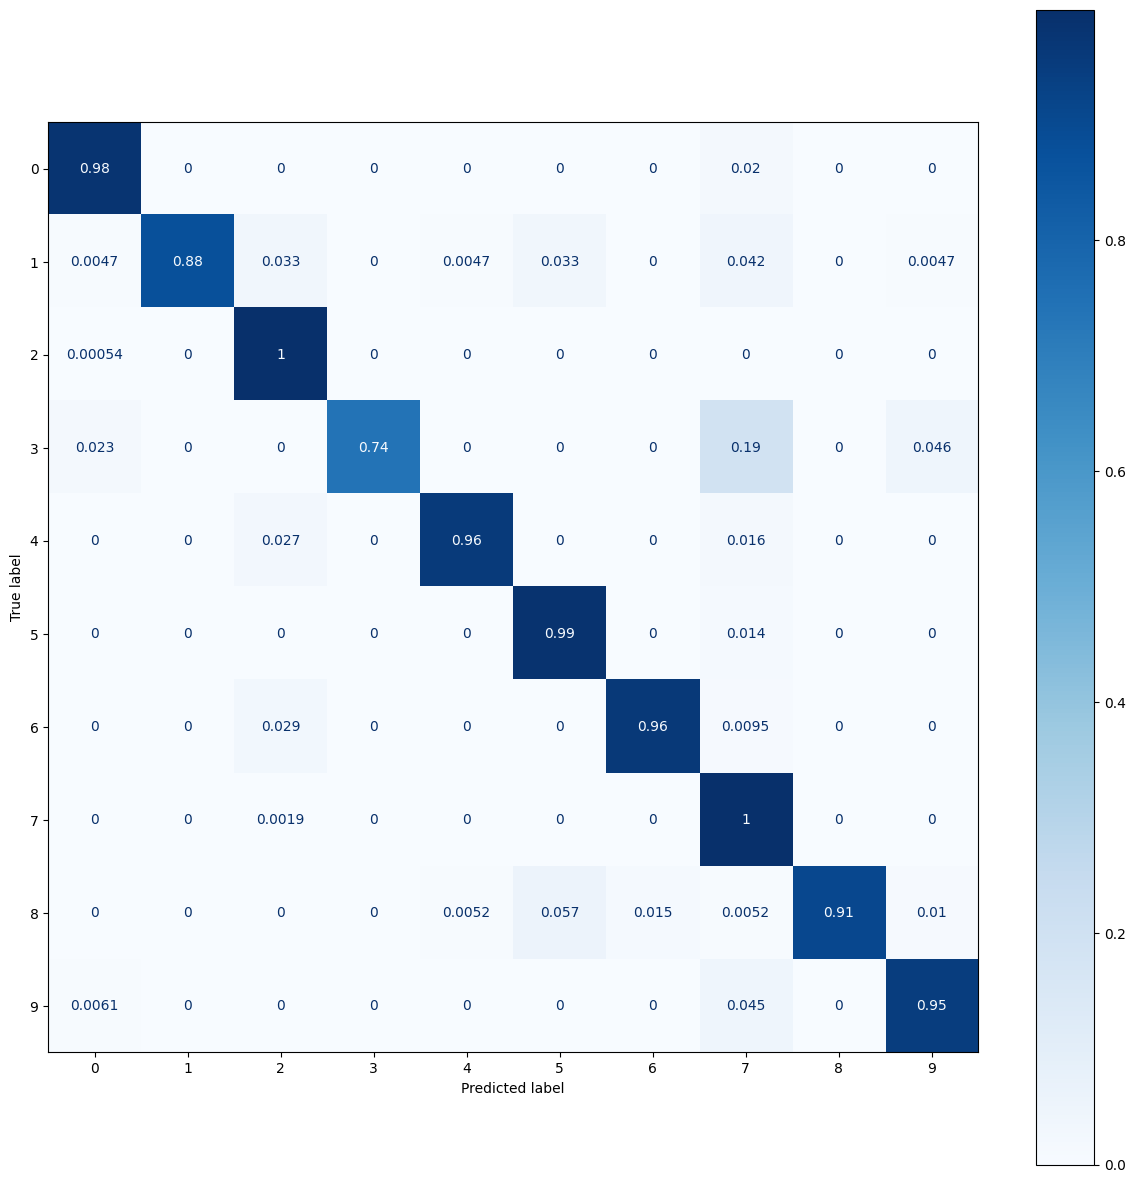

In [21]:
fig, ax = plt.subplots(figsize=(15, 15))
metrics.plot_confusion_matrix(model5, xvalid_tfidf_bi, y_test, cmap=plt.cm.Blues, normalize='true', ax=ax)

In [22]:
joblib.dump(model5, "models/MNB_top_10_bigram_tfidf.pkl")

['models/MNB_top_10_bigram_tfidf.pkl']

# Random Forest

In [23]:
print("\n ----------------------------------- Evaluation on Random Forest -----------------------------------n\n")
# Random Forest on Count Vectors
model1, accuracy = utils.train_ml_model(ensemble.RandomForestClassifier(n_estimators=100), 
                                        xtrain_count, xvalid_count, 
                                        y_train, y_test)
print("Random Forest, Count Vectors: ", accuracy)

# Random Forest on bigram Count Vectors
model2, accuracy = utils.train_ml_model(ensemble.RandomForestClassifier(n_estimators=100), 
                                        xtrain_count_bi, xvalid_count_bi, 
                                        y_train, y_test)
print("\nRandom Forest, bigram Count Vectors: ", accuracy)

# Random Forest on ngram Count Vectors
model3, accuracy = utils.train_ml_model(ensemble.RandomForestClassifier(n_estimators=100),
                                        xtrain_count_ngram, xvalid_count_ngram, 
                                        y_train, y_test)
print("\nRandom Forest, ngram Count Vectors: ", accuracy)

# Random Forest on Word Level TF IDF Vectors
model4, accuracy = utils.train_ml_model(ensemble.RandomForestClassifier(n_estimators=100),
                                        xtrain_tfidf, xvalid_tfidf, 
                                        y_train, y_test)
print("\nRandom Forest, WordLevel TF-IDF: ", accuracy)

# Random Forest on Word Level bigram TF IDF Vectors
model5, accuracy = utils.train_ml_model(ensemble.RandomForestClassifier(n_estimators=100),
                                        xtrain_tfidf_bi, xvalid_tfidf_bi,
                                        y_train, y_test)
print("\nRandom Forest, WordLevel bigram TF-IDF: ", accuracy)

# Random Forest on Ngram Level TF IDF Vectors
model6, accuracy = utils.train_ml_model(ensemble.RandomForestClassifier(n_estimators=100), 
                                        xtrain_tfidf_ngram, xvalid_tfidf_ngram, 
                                        y_train, y_test)
print("\nNRandom Forest, WordLevel ngram TF-IDF: ", accuracy)

# Random Forest on Character Level TF IDF Vectors
model7, accuracy = utils.train_ml_model(ensemble.RandomForestClassifier(n_estimators=100), 
                                        xtrain_tfidf_ngram_chars, xvalid_tfidf_ngram_chars,
                                        y_train, y_test)
print("\nRandom Forest, CharLevel ngram TF-IDF: ", accuracy)


 ----------------------------------- Evaluation on Random Forest -----------------------------------n

Random Forest, Count Vectors:  0.9847695390781563

Random Forest, bigram Count Vectors:  0.9877755511022044

Random Forest, ngram Count Vectors:  0.9877755511022044

Random Forest, WordLevel TF-IDF:  0.9801603206412826

Random Forest, WordLevel bigram TF-IDF:  0.9825651302605211

NRandom Forest, WordLevel ngram TF-IDF:  0.9843687374749499

Random Forest, CharLevel ngram TF-IDF:  0.9703406813627254


In [ ]:
# model1.predict()

## Performance Analysis:
* From the accuracies reported above, we can see that the ngram-based word frequency (unigrams, bigrams, and trigrams) representations give the best results.
* Other features also perform quite well.
* The performance of Random Forest is better than that of Multinomial Naive Bayes.
* However, the size of the Random Forest model is more than that of Multinomial Naive Bayes.
* The confusion matrix below also show a reasonable performance across all the labels and considerable improvement for label 3 (by 11%).

c:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


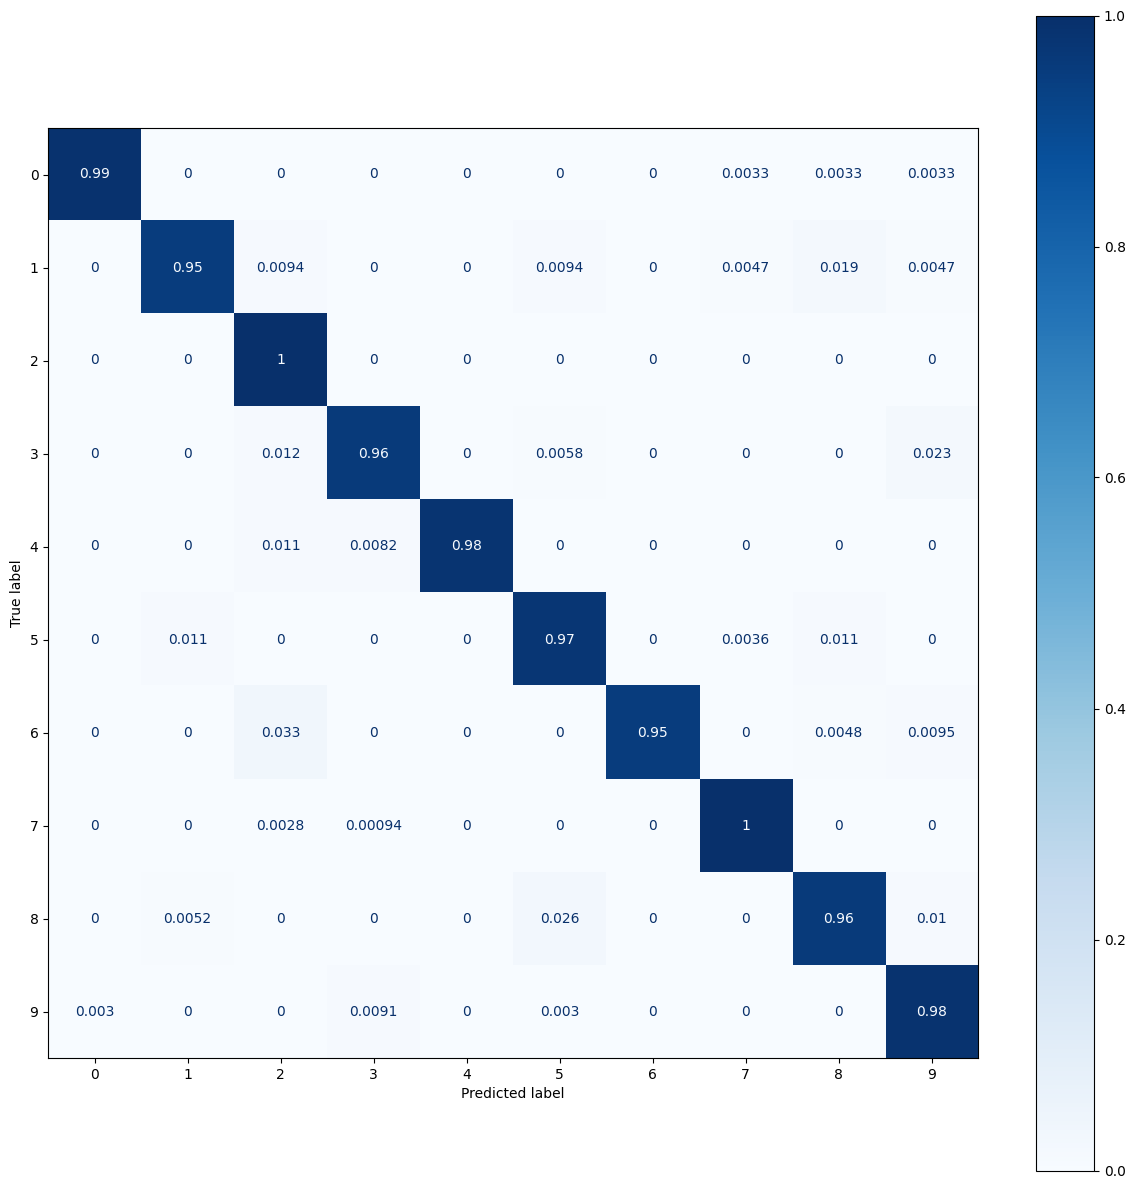

In [24]:
fig, ax = plt.subplots(figsize=(15, 15))
metrics.plot_confusion_matrix(model3, xvalid_count_ngram, y_test, cmap=plt.cm.Blues, normalize='true', ax=ax)

In [25]:
joblib.dump(model3, "models/RF_top_10_ngram_count.pkl")

['models/RF_top_10_ngram_count.pkl']

# Linear SVC

In [17]:
print("\n ----------------------------------- Evaluation on Linear SVC -----------------------------------n\n")
# LinearSVC on Count Vectors
model1, accuracy = utils.train_ml_model(LinearSVC(max_iter=15000),
                                        xtrain_count, xvalid_count,
                                        y_train, y_test)
print("LinearSVC, Count Vectors: ", accuracy)

# LinearSVC on bigram Count Vectors
model2, accuracy = utils.train_ml_model(LinearSVC(max_iter=15000), 
                                        xtrain_count_bi, xvalid_count_bi,
                                        y_train, y_test)
print("\nLinearSVC, bigram Count Vectors: ", accuracy)

# LinearSVC on ngram Count Vectors
model3, accuracy = utils.train_ml_model(LinearSVC(max_iter=20000), 
                                        xtrain_count_ngram, xvalid_count_ngram, 
                                        y_train, y_test)
print("\nLinearSVC, ngram Count Vectors: ", accuracy)

# LinearSVC on Word Level TF IDF Vectors
model4, accuracy = utils.train_ml_model(LinearSVC(max_iter=15000),
                                        xtrain_tfidf, xvalid_tfidf, 
                                        y_train, y_test)
print("\nLinearSVC, WordLevel TF-IDF: ", accuracy)

# LinearSVC on Word Level bigram TF IDF Vectors
model5, accuracy = utils.train_ml_model(LinearSVC(max_iter=15000), 
                                        xtrain_tfidf_bi, xvalid_tfidf_bi,
                                        y_train, y_test)
print("\nLinearSVC, WordLevel bigram TF-IDF: ", accuracy)

# LinearSVC on Ngram Level TF IDF Vectors
model6, accuracy = utils.train_ml_model(LinearSVC(max_iter=15000), 
                                        xtrain_tfidf_ngram, xvalid_tfidf_ngram, 
                                        y_train, y_test)
print("\nLinearSVC, WordLevel ngram TF-IDF: ", accuracy)

# LinearSVC on Character Level TF IDF Vectors
model7, accuracy = utils.train_ml_model(LinearSVC(max_iter=15000),
                                        xtrain_tfidf_ngram_chars, xvalid_tfidf_ngram_chars, 
                                        y_train, y_test)
print("\nLinearSVC, CharLevel ngram TF-IDF: ", accuracy)


 ----------------------------------- Evaluation on Linear SVC -----------------------------------n

LinearSVC, Count Vectors:  0.98937875751503

LinearSVC, bigram Count Vectors:  0.9879759519038076

LinearSVC, ngram Count Vectors:  0.9871743486973948

LinearSVC, WordLevel TF-IDF:  0.992184368737475

LinearSVC, WordLevel bigram TF-IDF:  0.9927855711422846

LinearSVC, WordLevel ngram TF-IDF:  0.9917835671342685

LinearSVC, CharLevel ngram TF-IDF:  0.9895791583166332


## Performance Analysis:
* From the accuracies reported above, we can see that the word TF-IDF representations (unigrams and bigrams) give the best results.
* Other features also perform quite well.
* The performance of Linear SVC is better than that of Multinomial Naive Bayes and Random Forest.
* Moreover, the size of the Linear SVC model is much less than that of Random Forest and Multinomial Naive Bayes.
* The confusion matrix below also show a good performance across all the labels.

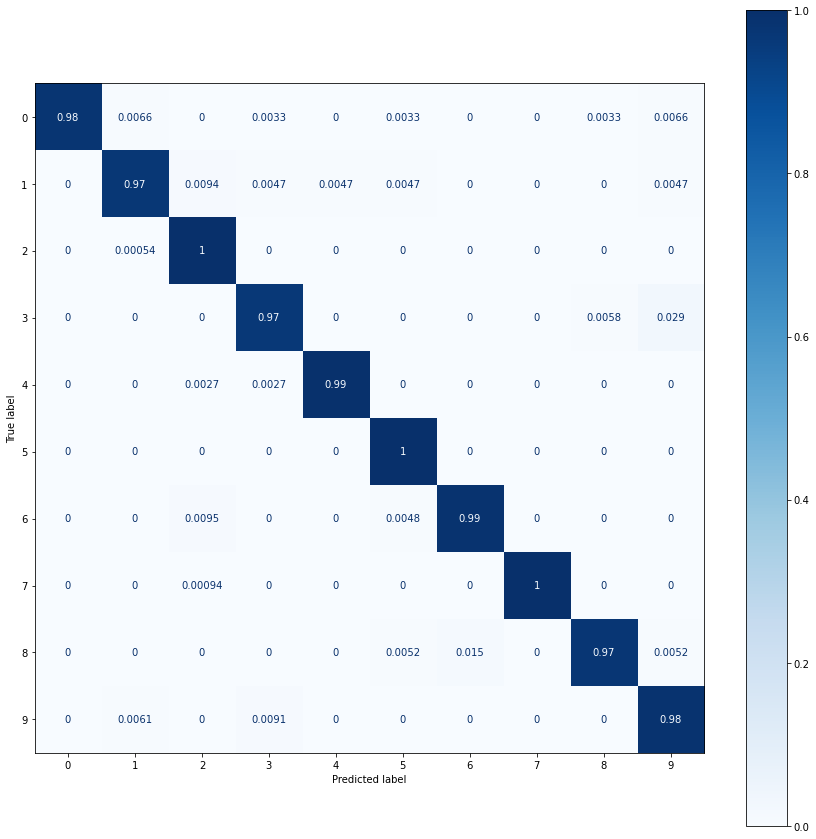

In [18]:
fig, ax = plt.subplots(figsize=(15, 15))
metrics.plot_confusion_matrix(model5, xvalid_tfidf_bi, y_test, cmap=plt.cm.Blues, normalize='true', ax=ax)

In [19]:
joblib.dump(model5, "models/LinearSVC_top_10_bigram_tfidf.pkl")

['models/LinearSVC_top_10_bigram_tfidf.pkl']

## Evlaulating the performance using the top 25 most occuring categories as labels

In [26]:
data = utils.read_data("dataset.tsv", 
                       sep="\t", 
                       usecols=['uniq_id', 'product_name', 'product_category_tree', 'description'])
data

,uniq_id,product_name,product_category_tree,description
0,c2d766ca982eca8304150849735ffef9,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",Key Features of Alisha Solid Women's Cycling S...
1,7f7036a6d550aaa89d34c77bd39a5e48,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",FabHomeDecor Fabric Double Sofa Bed (Finish Co...
2,f449ec65dcbc041b6ae5e6a32717d01b,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",Key Features of AW Bellies Sandals Wedges Heel...
3,0973b37acd0c664e3de26e97e5571454,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",Key Features of Alisha Solid Women's Cycling S...
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",Specifications of Sicons All Purpose Arnica Do...
...,...,...,...,...
19995,7179d2f6c4ad50a17d014ca1d2815156,WallDesign Small Vinyl Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Buy WallDesign Small Vinyl Sticker for Rs.730 ...
19996,71ac419198359d37b8fe5e3fffdfee09,Wallmantra Large Vinyl Stickers Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Buy Wallmantra Large Vinyl Stickers Sticker fo...
19997,93e9d343837400ce0d7980874ece471c,Elite Collection Medium Acrylic Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Buy Elite Collection Medium Acrylic Sticker fo...
19998,669e79b8fa5d9ae020841c0c97d5e935,Elite Collection Medium Acrylic Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Buy Elite Collection Medium Acrylic Sticker fo...


### generate_label function:
This function below is used to parse the product category tree and generate the primary label the product belongs to.

In [27]:
data = utils.generate_label(data, top=25)
data.label.value_counts()

Clothing                             6198
Jewellery                            3531
Footwear                             1227
Mobiles & Accessories                1099
Automotive                           1012
Home Decor & Festive Needs            929
Beauty and Personal Care              710
Home Furnishing                       700
Kitchen & Dining                      647
Computers                             578
Watches                               530
Baby Care                             483
Tools & Hardware                      391
Toys & School Supplies                330
Pens & Stationery                     313
Bags, Wallets & Belts                 265
Furniture                             180
Sports & Fitness                      166
Cameras & Accessories                  82
Home Improvement                       81
Health & Personal Care Appliances      43
Gaming                                 35
Sunglasses                             35
Pet Supplies                      

As we can see below 19,619 samples out of the total 20k samples cover the top 10 categories which covers about 98%, that is almost the entire dataset. So considering top 25 categories seems optimal.

In [28]:
print(len(data))

19619


(array([   0., 1000., 2000., 3000., 4000., 5000., 6000., 7000.]),
 [Text(0.0, 0, '0'),
  Text(1000.0, 0, '1000'),
  Text(2000.0, 0, '2000'),
  Text(3000.0, 0, '3000'),
  Text(4000.0, 0, '4000'),
  Text(5000.0, 0, '5000'),
  Text(6000.0, 0, '6000'),
  Text(7000.0, 0, '7000')])

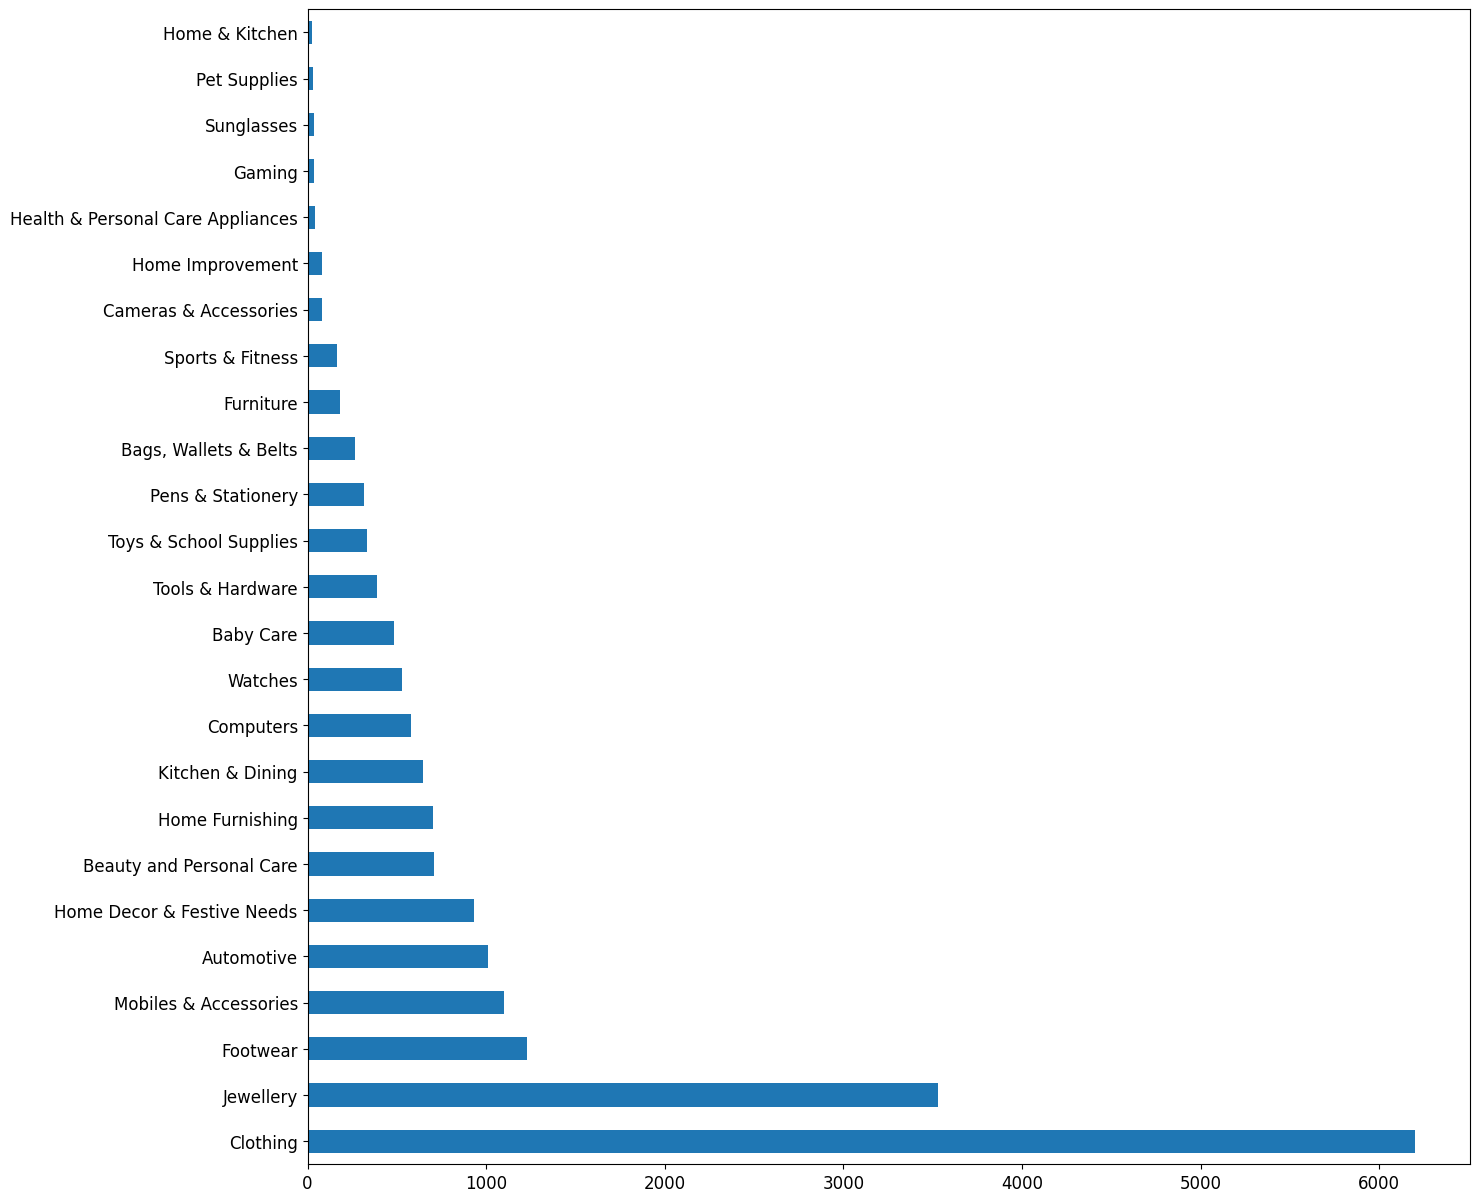

In [29]:
plt.figure(figsize=(15,15))
data['label'].value_counts().sort_values(ascending=False).plot(kind='barh')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

## prepare_data function:
* It is used to preprocess the textual description and prepare labels.
* The text preprocessing includes removing emails, new line characters, distracting single quotes, digits, puntuations, single characters, accented words, and multiple spaces.
* Removal of the stopwords (except the negation words) and lemmatization is optional. However, the lemmatizaiton and stopwords removal is done as it gives empirically improves performance.
* It also splits the data into train and test sets.
* A stratified 70:30 train-test split is used, which gives 13,733 train samples and 5,886 test samples when the top 10 product categories are included.

In [24]:
x_train, x_test, y_train, y_test = utils.prepare_data(data, test_size=0.3, remove_stopwords=True, lemmatize=True)

print("Total training examples: ", len(x_train))
print("Total test examples: ", len(x_test))

Total training examples:  13733
Total test examples:  5886


## Feature Engineering:
* The ML models cannot handle textual data. So it needs to be converted to a numeric format.
* 7 feature engineering techniques to convert the input textual descriptions into numeric features.
    1. Word frequency based representation (only unigrams).
    2. Word frequency based representation (unigrams and bigrams).
    3. Word frequency based representation (unigrams, bigrams, and trigrams).
    4. Word TF-IDF based representation (only unigrams).
    5. Word TF-IDF based representation (unigrams and bigrams).
    6. Word TF-IDF based representation (unigrams, bigrams, and trigrams).
    7. Character TF-IDF based representation (bigrams and trigrams).

In [27]:
# Prepare text data features

xtrain_count, xvalid_count = utils.count_vectorize(x_train, 
                                                   x_test,
                                                   analyzer='word', 
                                                   token_pattern=r'\w{1,}', 
                                                   max_features=10000, 
                                                   ngram_range=(1,1))

xtrain_count_bi, xvalid_count_bi = utils.count_vectorize(x_train, 
                                                         x_test,
                                                         analyzer='word', 
                                                         token_pattern=r'\w{1,}', 
                                                         max_features=10000, 
                                                         ngram_range=(1,2))

xtrain_count_ngram, xvalid_count_ngram = utils.count_vectorize(x_train, 
                                                               x_test,
                                                               analyzer='word', 
                                                               token_pattern=r'\w{1,}', 
                                                               max_features=10000, 
                                                               ngram_range=(1,3))


xtrain_tfidf, xvalid_tfidf = utils.tf_idf_vectorize(x_train, 
                                                    x_test, 
                                                    analyzer='word', 
                                                    token_pattern=r'\w{1,}', 
                                                    max_features=10000, 
                                                    ngram_range=(1,1))


xtrain_tfidf_bi, xvalid_tfidf_bi = utils.tf_idf_vectorize(x_train, 
                                                          x_test, 
                                                          analyzer='word', 
                                                          token_pattern=r'\w{1,}', 
                                                          max_features=10000, 
                                                          ngram_range=(1,2))


xtrain_tfidf_ngram, xvalid_tfidf_ngram = utils.tf_idf_vectorize(x_train, 
                                                                x_test,
                                                                analyzer='word', 
                                                                token_pattern=r'\w{1,}', 
                                                                max_features=10000, 
                                                                ngram_range=(1,3))

xtrain_tfidf_ngram_chars, xvalid_tfidf_ngram_chars = utils.tf_idf_vectorize(x_train, 
                                                                            x_test,
                                                                            analyzer='char', 
                                                                            token_pattern=r'\w{1,}', 
                                                                            max_features=10000, 
                                                                            ngram_range=(2,3))
print("\nPrepared features for Input data")


Prepared features for Input data


# Multinomial Naive Bayes

In [28]:
print("\n ----------------------------------- Evaluation on Multinomial Naive Bayes -----------------------------------n\n")
# Naive Bayes on Count Vectors
model1, accuracy = utils.train_ml_model(naive_bayes.MultinomialNB(), 
                                        xtrain_count, xvalid_count, 
                                        y_train, y_test)
print("Naive Bayes, Count Vectors: ", accuracy)

# Naive Bayes on bigram Count Vectors
model2, accuracy = utils.train_ml_model(naive_bayes.MultinomialNB(),
                                        xtrain_count_bi, xvalid_count_bi,
                                        y_train, y_test)
print("\nNaive Bayes, bigram Count Vectors: ", accuracy)

# Naive Bayes on ngram Count Vectors
model3, accuracy = utils.train_ml_model(naive_bayes.MultinomialNB(),
                                        xtrain_count_ngram, xvalid_count_ngram,
                                        y_train, y_test)
print("\nNaive Bayes, ngram Count Vectors: ", accuracy)

# Naive Bayes on Word Level TF IDF Vectors
model4, accuracy = utils.train_ml_model(naive_bayes.MultinomialNB(),
                                        xtrain_tfidf, xvalid_tfidf,
                                        y_train, y_test)
print("\nNaive Bayes, WordLevel TF-IDF: ", accuracy)

# Naive Bayes on Word Level bigram TF IDF Vectors
model5, accuracy = utils.train_ml_model(naive_bayes.MultinomialNB(),
                                        xtrain_tfidf_bi, xvalid_tfidf_bi,
                                        y_train, y_test)
print("\nNaive Bayes, WordLevel bigram TF-IDF: ", accuracy)

# Naive Bayes on Ngram Level TF IDF Vectors
model6, accuracy = utils.train_ml_model(naive_bayes.MultinomialNB(),
                                        xtrain_tfidf_ngram, xvalid_tfidf_ngram,
                                        y_train, y_test)
print("\nNaive Bayes, WordLevel ngram TF-IDF: ", accuracy)

# Naive Bayes on Character Level TF IDF Vectors
model7, accuracy = utils.train_ml_model(naive_bayes.MultinomialNB(),
                                        xtrain_tfidf_ngram_chars, xvalid_tfidf_ngram_chars,
                                        y_train, y_test)
print("\nNaive Bayes, CharLevel ngram TF-IDF: ", accuracy)


 ----------------------------------- Evaluation on Multinomial Naive Bayes -----------------------------------n

Naive Bayes, Count Vectors:  0.9384981311586816

Naive Bayes, bigram Count Vectors:  0.9330615018688413

Naive Bayes, ngram Count Vectors:  0.917601087325858

Naive Bayes, WordLevel TF-IDF:  0.8826027862725111

Naive Bayes, WordLevel bigram TF-IDF:  0.9218484539585458

Naive Bayes, WordLevel ngram TF-IDF:  0.9215086646279307

Naive Bayes, CharLevel ngram TF-IDF:  0.7697927285083248


## Performance Analysis:
* From the accuracies reported above, we can see that the simple unigram-based word frequency representations give the best results.
* The performance drops by about 4-5% for each feature when the number of labels are increased.
* The confusion matrix below also show a reasonable performance except for label 1, 4, 9, 10, 14, 18, 19, 20, where the accuracy is below 70%.

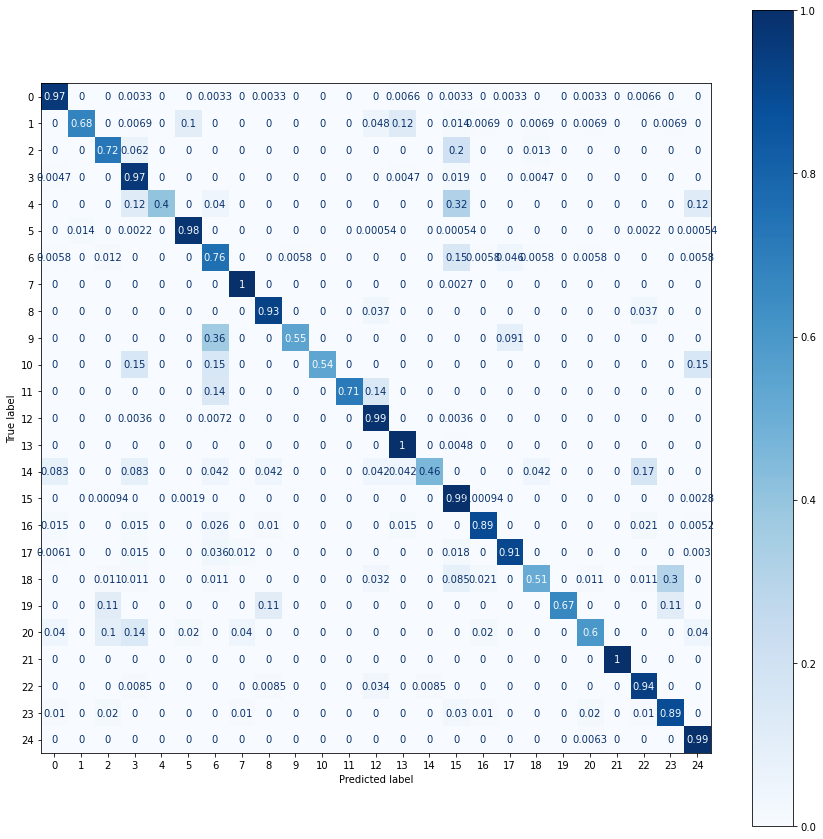

In [29]:
fig, ax = plt.subplots(figsize=(15, 15))
metrics.plot_confusion_matrix(model1, xvalid_count, y_test, cmap=plt.cm.Blues, normalize='true', ax=ax)

In [30]:
joblib.dump(model1, "models/MNB_top_25_count.pkl")

['models/MNB_top_25_count.pkl']

# Random Forest

In [31]:
print("\n ----------------------------------- Evaluation on Random Forest -----------------------------------n\n")
# Random Forest on Count Vectors
model1, accuracy = utils.train_ml_model(ensemble.RandomForestClassifier(n_estimators=100), 
                                        xtrain_count, xvalid_count, 
                                        y_train, y_test)
print("Random Forest, Count Vectors: ", accuracy)

# Random Forest on bigram Count Vectors
model2, accuracy = utils.train_ml_model(ensemble.RandomForestClassifier(n_estimators=100), 
                                        xtrain_count_bi, xvalid_count_bi, 
                                        y_train, y_test)
print("\nRandom Forest, bigram Count Vectors: ", accuracy)

# Random Forest on ngram Count Vectors
model3, accuracy = utils.train_ml_model(ensemble.RandomForestClassifier(n_estimators=100),
                                        xtrain_count_ngram, xvalid_count_ngram, 
                                        y_train, y_test)
print("\nRandom Forest, ngram Count Vectors: ", accuracy)

# Random Forest on Word Level TF IDF Vectors
model4, accuracy = utils.train_ml_model(ensemble.RandomForestClassifier(n_estimators=100),
                                        xtrain_tfidf, xvalid_tfidf, 
                                        y_train, y_test)
print("\nRandom Forest, WordLevel TF-IDF: ", accuracy)

# Random Forest on Word Level bigram TF IDF Vectors
model5, accuracy = utils.train_ml_model(ensemble.RandomForestClassifier(n_estimators=100),
                                        xtrain_tfidf_bi, xvalid_tfidf_bi,
                                        y_train, y_test)
print("\nRandom Forest, WordLevel bigram TF-IDF: ", accuracy)

# Random Forest on Ngram Level TF IDF Vectors
model6, accuracy = utils.train_ml_model(ensemble.RandomForestClassifier(n_estimators=100), 
                                        xtrain_tfidf_ngram, xvalid_tfidf_ngram, 
                                        y_train, y_test)
print("\nNRandom Forest, WordLevel ngram TF-IDF: ", accuracy)

# Random Forest on Character Level TF IDF Vectors
model7, accuracy = utils.train_ml_model(ensemble.RandomForestClassifier(n_estimators=100), 
                                        xtrain_tfidf_ngram_chars, xvalid_tfidf_ngram_chars,
                                        y_train, y_test)
print("\nRandom Forest, CharLevel ngram TF-IDF: ", accuracy)


 ----------------------------------- Evaluation on Random Forest -----------------------------------n

Random Forest, Count Vectors:  0.9655113829425757

Random Forest, bigram Count Vectors:  0.9717974855589534

Random Forest, ngram Count Vectors:  0.972646958885491

Random Forest, WordLevel TF-IDF:  0.9600747536527353

Random Forest, WordLevel bigram TF-IDF:  0.9629629629629629

NRandom Forest, WordLevel ngram TF-IDF:  0.962623173632348

Random Forest, CharLevel ngram TF-IDF:  0.9475025484199796


## Performance Analysis:
* From the accuracies reported above, we can see that the ngram-based word frequency (unigrams, bigrams, and trigrams) representations yet again give the best results.
* Other features also perform quite well.
* The performance of Random Forest is better than that of Multinomial Naive Bayes.
* However, the size of the Random Forest model is more than that of Multinomial Naive Bayes.
* As opposed to Multinomial Naive Bayes, the performance of Random Forest does not drop drastically when the labels are increased from 10 to 25.
* The confusion matrix below also show a reasonable performance across all the labels except for label 9 and 11.

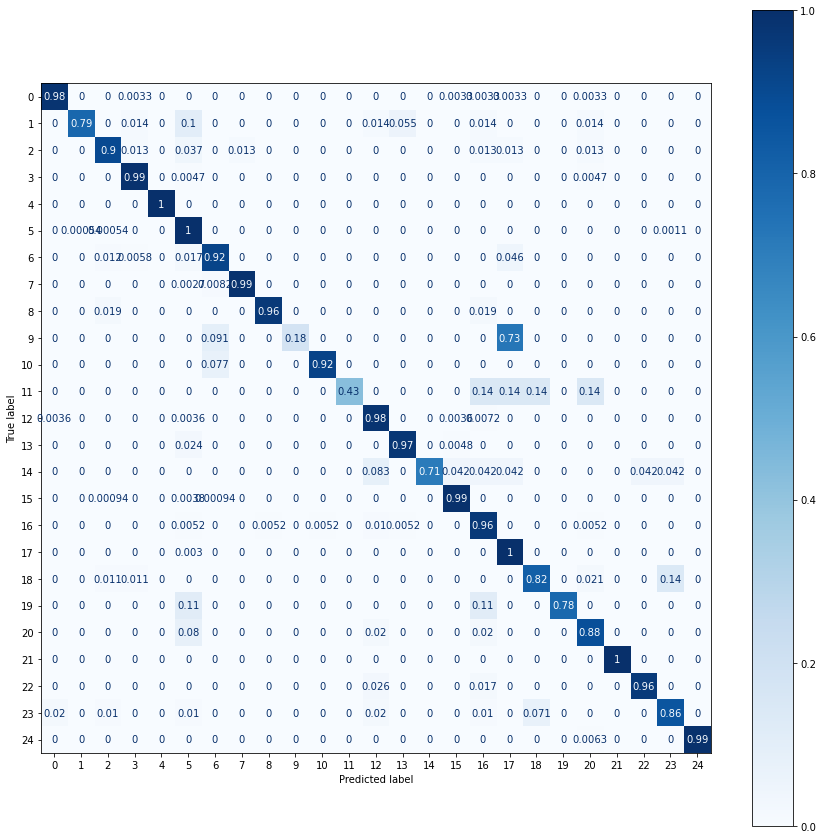

In [32]:
fig, ax = plt.subplots(figsize=(15, 15))
metrics.plot_confusion_matrix(model3, xvalid_count_ngram, y_test, cmap=plt.cm.Blues, normalize='true', ax=ax)

In [33]:
joblib.dump(model3, "models/RF_top_25_ngram_count.pkl")

['models/RF_top_25_ngram_count.pkl']

# Linear SVC

In [34]:
print("\n ----------------------------------- Evaluation on Linear SVC -----------------------------------n\n")
# LinearSVC on Count Vectors
model1, accuracy = utils.train_ml_model(LinearSVC(max_iter=15000),
                                        xtrain_count, xvalid_count,
                                        y_train, y_test)
print("LinearSVC, Count Vectors: ", accuracy)

# LinearSVC on bigram Count Vectors
model2, accuracy = utils.train_ml_model(LinearSVC(max_iter=15000), 
                                        xtrain_count_bi, xvalid_count_bi,
                                        y_train, y_test)
print("\nLinearSVC, bigram Count Vectors: ", accuracy)

# LinearSVC on ngram Count Vectors
model3, accuracy = utils.train_ml_model(LinearSVC(max_iter=20000), 
                                        xtrain_count_ngram, xvalid_count_ngram, 
                                        y_train, y_test)
print("\nLinearSVC, ngram Count Vectors: ", accuracy)

# LinearSVC on Word Level TF IDF Vectors
model4, accuracy = utils.train_ml_model(LinearSVC(max_iter=15000),
                                        xtrain_tfidf, xvalid_tfidf, 
                                        y_train, y_test)
print("\nLinearSVC, WordLevel TF-IDF: ", accuracy)

# LinearSVC on Word Level bigram TF IDF Vectors
model5, accuracy = utils.train_ml_model(LinearSVC(max_iter=15000), 
                                        xtrain_tfidf_bi, xvalid_tfidf_bi,
                                        y_train, y_test)
print("\nLinearSVC, WordLevel bigram TF-IDF: ", accuracy)

# LinearSVC on Ngram Level TF IDF Vectors
model6, accuracy = utils.train_ml_model(LinearSVC(max_iter=15000), 
                                        xtrain_tfidf_ngram, xvalid_tfidf_ngram, 
                                        y_train, y_test)
print("\nLinearSVC, WordLevel ngram TF-IDF: ", accuracy)

# LinearSVC on Character Level TF IDF Vectors
model7, accuracy = utils.train_ml_model(LinearSVC(max_iter=15000),
                                        xtrain_tfidf_ngram_chars, xvalid_tfidf_ngram_chars, 
                                        y_train, y_test)
print("\nLinearSVC, CharLevel ngram TF-IDF: ", accuracy)


 ----------------------------------- Evaluation on Linear SVC -----------------------------------n

LinearSVC, Count Vectors:  0.9704383282364933

LinearSVC, bigram Count Vectors:  0.971967380224261

LinearSVC, ngram Count Vectors:  0.9697587495752633

LinearSVC, WordLevel TF-IDF:  0.9763846415222562

LinearSVC, WordLevel bigram TF-IDF:  0.9772341148487937

LinearSVC, WordLevel ngram TF-IDF:  0.9777437988447163

LinearSVC, CharLevel ngram TF-IDF:  0.9738362215426436


## Performance Analysis:
* From the accuracies reported above, we can see that the word TF-IDF representations (unigrams, bigrams, and trigrams) give the best results.
* Other features also perform quite well.
* The performance of Linear SVC is better than that of Multinomial Naive Bayes and Random Forest.
* Moreover, the size of the Linear SVC model is much less than that of Random Forest and Multinomial Naive Bayes.
* The confusion matrix below also show a good performance across all the labels.
* The performance is slightly below par only for label 9.

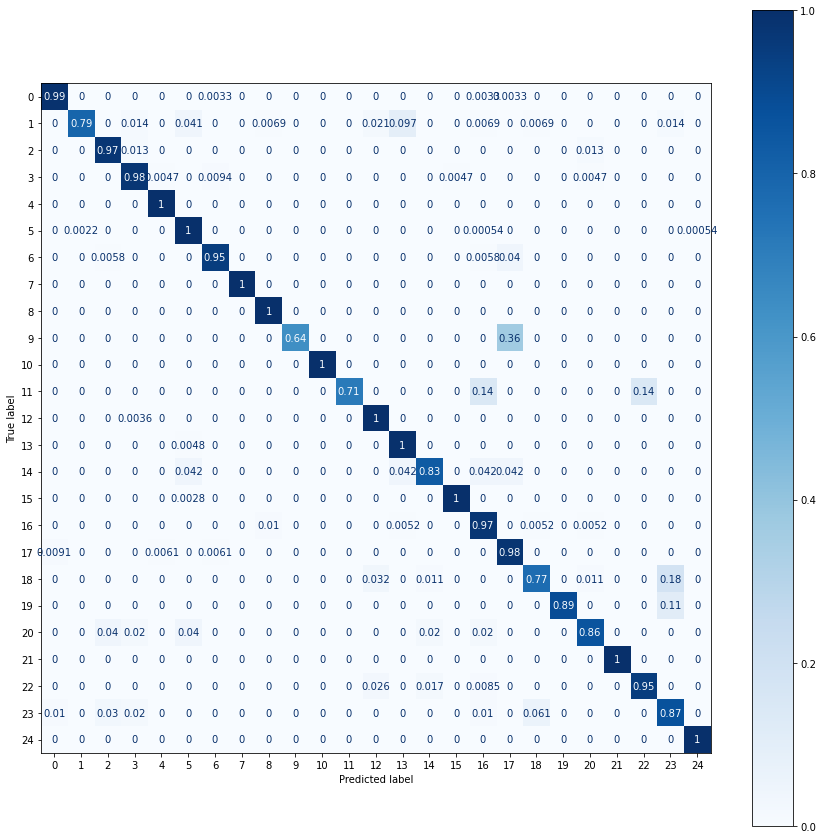

In [35]:
fig, ax = plt.subplots(figsize=(15, 15))
metrics.plot_confusion_matrix(model6, xvalid_tfidf_ngram, y_test, cmap=plt.cm.Blues, normalize='true', ax=ax)

In [36]:
joblib.dump(model5, "models/LinearSVC_top_25_ngram_tfidf.pkl")

['models/LinearSVC_top_25_ngram_tfidf.pkl']

# Conclusion:
* The simple Machine learning models give quite a good performance for the task at hand.
* Thus, I didn't feel the need to train deep learning models (DNN, CNN, LSTM) or other complex architectures (BERT, etc).
* It can be infered that Linear SVC is better than Multinomial Naive Bayes and Random Forest in terms of performance as well as memory.
* The performance can be further improved by opting for a multimodal approach, extracting the information from the product's images.